#  Predicting Future Sales 

The first step is to load all the required libraries.

In [2]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Next, Loading the data sets into memeory.

In [3]:
sales = pd.read_csv('sales_train.csv')
test_data = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
item_category = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


This fuction is to reduce the size of data

In [9]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

It is required to add lagged data as new features. 
Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

In [10]:
def lag_feature(all_data, list_lags, index_cols, cols_to_rename):
    shift_range = list_lags

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()
    
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift
    return all_data

Here is how data looks like.

Plotted sales of shops per month, in order to see the general behavior

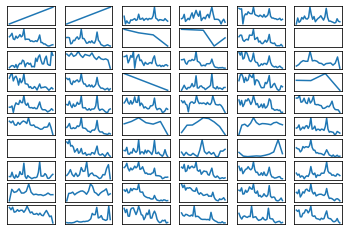

In [11]:
Monthly_sales = sales.groupby(["date_block_num", "shop_id"])['item_cnt_day'].sum().reset_index(name = 'item_cnt_month')


fig, axs = plt.subplots(10, 6)

for i in range(60):
    shop_sale_per_month = Monthly_sales.loc[Monthly_sales['shop_id']==i]
    axs[i//6,i%6].tick_params(axis='both', which='both', bottom=False, top= False, labelbottom=False, right=False, left=False, labelleft=False)
    axs[i//6,i%6].plot(shop_sale_per_month['date_block_num'], shop_sale_per_month['item_cnt_month'])


del Monthly_sales, shop_sale_per_month

In general, sales have seasonal behaviour as expected. However, some shops show abnormal behaviour which turned out to be duplication issue and fixed as follows. Also, we removed the outliers from data.

In [12]:
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
test_data.loc[test_data.shop_id == 0, 'shop_id'] = 57

sales.loc[sales.shop_id == 1, 'shop_id'] = 58
test_data.loc[test_data.shop_id == 1, 'shop_id'] = 58

sales.loc[sales.shop_id == 10, 'shop_id'] = 11
test_data.loc[test_data.shop_id == 10, 'shop_id'] = 11


# remove the oulier
sales = sales[sales.item_cnt_day<1001]

Finding the number of unique shop-item combinations that only exist in test data

In [13]:
temp_df = pd.merge(test_data[['shop_id','item_id']],sales[['shop_id','item_id']], on=['shop_id','item_id'], how='left', indicator='Exist')
temp_var =  (temp_df['Exist']=='left_only').sum()
print('Number of unique shop-item combination in the test set that do not exist in the training set:',temp_var)

Number of unique shop-item combination in the test set that do not exist in the training set: 102729


As we can see, about 52% of combinations already exists in the training set. Going to use them if any leaked is found.

In [14]:
Leakage_Percentage = ((test_data.shape[0]-temp_var)/test_data.shape[0])*100
print('Percentage of shop-item combination in test data that are available in the training set:', Leakage_Percentage)

Percentage of shop-item combination in test data that are available in the training set: 52.040616246498594


The following code is based in assignments and it will be used in order to create all posible combinations of shop-items and fill out the target column.

In [15]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':['sum']})
gb.rename(columns = {'sum':'target'}, inplace = True) 

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
all_data['target'] = all_data['target'].fillna(0).clip(0,20)

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 
all_data

,shop_id,item_id,date_block_num,target
4556102,2,27,12,0.0
4551998,2,30,12,0.0
4552559,2,31,12,0.0
4552263,2,32,12,1.0
4552274,2,33,12,1.0
...,...,...,...,...
10768834,59,22162,33,0.0
10769024,59,22163,33,0.0
10769690,59,22164,33,0.0
10771216,59,22166,33,0.0


Adding the following features:

City code from the shops csv
Category ID
The text data in item category gives some extra info that can be used such as the basket of commodities that an item belongs to

In [16]:
# Adding city_enc column
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city_enc'] = LabelEncoder().fit_transform(shops['city'])
shops_data = shops[['shop_id','city_enc']]
all_data = pd.merge(all_data, shops_data, how='left', on=['shop_id'])

# Adding item_category_id column
all_data = pd.merge(all_data, items, how='left', on=['item_id'])
all_data = all_data.drop('item_name',axis =1)

# Adding basket_enc column
item_category['basket'] = item_category['item_category_name'].apply(lambda x: str(x).split(' ')[0])
item_category['basket_enc'] = LabelEncoder().fit_transform(item_category['basket'])
item_category = item_category[['item_category_id','basket_enc']]
all_data = pd.merge(all_data, item_category, how='left', on=['item_category_id'])
all_data

,shop_id,item_id,date_block_num,target,city_enc,item_category_id,basket_enc
0,2,27,12,0.0,0,19,5
1,2,30,12,0.0,0,40,7
2,2,31,12,0.0,0,37,7
3,2,32,12,1.0,0,40,7
4,2,33,12,1.0,0,37,7
...,...,...,...,...,...,...,...
6425089,59,22162,33,0.0,30,40,7
6425090,59,22163,33,0.0,30,40,7
6425091,59,22164,33,0.0,30,37,7
6425092,59,22166,33,0.0,30,54,8


Adding the test data

In [17]:
all_data = pd.concat([all_data, test_data], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id', 'city_enc', 'item_category_id', 'basket_enc', 'target'])
all_data = downcast_dtypes(all_data)
all_data

,shop_id,item_id,date_block_num,target,city_enc,item_category_id,basket_enc,ID
0,2,27,12.0,0.0,0.0,19.0,5.0,NaN
1,2,30,12.0,0.0,0.0,40.0,7.0,NaN
2,2,31,12.0,0.0,0.0,37.0,7.0,NaN
3,2,32,12.0,1.0,0.0,40.0,7.0,NaN
4,2,33,12.0,1.0,0.0,37.0,7.0,NaN
...,...,...,...,...,...,...,...,...
6639289,45,18454,NaN,NaN,NaN,NaN,NaN,214195.0
6639290,45,16188,NaN,NaN,NaN,NaN,NaN,214196.0
6639291,45,15757,NaN,NaN,NaN,NaN,NaN,214197.0
6639292,45,19648,NaN,NaN,NaN,NaN,NaN,214198.0


Aggregating the data

In [18]:
# shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':['sum']})
gb.rename(columns = {'sum':'target_shop'}, inplace = True)

gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':['sum']})
gb.rename(columns = {'sum':'target_item'}, inplace = True)
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

all_data = downcast_dtypes(all_data)

all_data

,shop_id,item_id,date_block_num,target,city_enc,item_category_id,basket_enc,ID,target_shop,target_item
0,2,27,12.0,0.0,0.0,19.0,5.0,0.0,890.0,1.0
1,2,30,12.0,0.0,0.0,40.0,7.0,0.0,890.0,58.0
2,2,31,12.0,0.0,0.0,37.0,7.0,0.0,890.0,15.0
3,2,32,12.0,1.0,0.0,40.0,7.0,0.0,890.0,84.0
4,2,33,12.0,1.0,0.0,37.0,7.0,0.0,890.0,42.0
...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,0.0,0.0,0.0,0.0,0.0,214195.0,0.0,0.0
6639290,45,16188,0.0,0.0,0.0,0.0,0.0,214196.0,0.0,0.0
6639291,45,15757,0.0,0.0,0.0,0.0,0.0,214197.0,0.0,14.0
6639292,45,19648,0.0,0.0,0.0,0.0,0.0,214198.0,0.0,0.0


Adding lagged data. Based on our analysis using trial and error, We found just lagged data for previous 3 months has highest impact.

In [19]:
from tqdm import tqdm_notebook

index_cols = ['shop_id', 'item_id', 'date_block_num', 'item_category_id', 'basket_enc', 'city_enc']
cols_to_rename = list(all_data.columns.difference(index_cols)) 
list_lags = [1, 2, 3]
all_data = lag_feature(all_data, list_lags, index_cols, cols_to_rename)
all_data = downcast_dtypes(all_data)

all_data
import warnings warnings.filterwarnings ('ignore')

c:\users\thanniru srinivas\anaconda3\envs\salesprediction\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


,shop_id,item_id,date_block_num,target,city_enc,item_category_id,basket_enc,ID,target_shop,target_item,...,target_item_lag_1,target_shop_lag_1,ID_lag_2,target_lag_2,target_item_lag_2,target_shop_lag_2,ID_lag_3,target_lag_3,target_item_lag_3,target_shop_lag_3
0,2,27,12.0,0.0,0.0,19.0,5.0,0.0,890.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,12.0,0.0,0.0,40.0,7.0,0.0,890.0,58.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,12.0,0.0,0.0,37.0,7.0,0.0,890.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,32,12.0,1.0,0.0,40.0,7.0,0.0,890.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,33,12.0,1.0,0.0,37.0,7.0,0.0,890.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,0.0,0.0,0.0,0.0,0.0,214195.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6639290,45,16188,0.0,0.0,0.0,0.0,0.0,214196.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6639291,45,15757,0.0,0.0,0.0,0.0,0.0,214197.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6639292,45,19648,0.0,0.0,0.0,0.0,0.0,214198.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are going to train two LGBM and random forest model and later stack them.

In [20]:
shift_range = list_lags

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
del sales, grid
to_drop_cols

['ID', 'target_shop', 'target_item', 'target', 'date_block_num']

In [21]:
X_train = all_data[all_data.date_block_num < 33].drop(to_drop_cols, axis=1)
Y_train = all_data[all_data.date_block_num < 33]['target']
X_valid = all_data[all_data.date_block_num == 33].drop(to_drop_cols, axis=1)
Y_valid = all_data[all_data.date_block_num == 33]['target']
X_test = all_data[all_data.date_block_num == 34].drop(to_drop_cols, axis=1)

In [22]:
X = X_train.append(X_valid)
Y = np.append(Y_train, Y_valid)

In [23]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.05, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }
lgb = lgb.train(lgb_params, lgb.Dataset(X, label=Y), 100)

pred_lgb_val = lgb.predict(X_valid)

print('Train mse is %f' % mean_squared_error(Y_train, lgb.predict(X_train)))
print('Val mse is %f' % mean_squared_error(Y_valid, pred_lgb_val))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.110737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Train mse is 0.723875
Val mse is 0.780986


In [24]:
rf = RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=10,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
rf.fit(X,Y)

pred_rf_val = rf.predict(X_valid)
print('Train mse is %f' % mean_squared_error(Y_train, rf.predict(X_train)))
print('Val mse is %f' % mean_squared_error(Y_valid, pred_rf_val))

Train mse is 0.801572
Val mse is 0.887723


Stacking two models in order to improve the model.

In [25]:
X_val_level2 = np.c_[pred_rf_val, pred_lgb_val]

lr = LinearRegression()
lr.fit(X_val_level2, Y_valid)
pred_lr_val =  lr.predict(X_val_level2)
print('Test mse is %f' % mean_squared_error(Y_valid, pred_lr_val))

Test mse is 0.779689
